# Project Setup and Imports

In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression as DaskLinearRegression
from dask_ml.preprocessing import StandardScaler as DaskStandardScaler

import pandas as pd
import numpy as np
import os
import shutil
import time
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Ensure reproducibility for data generation
np.random.seed(42)

print(f"Dask version: {dask.__version__}")

Dask version: 2025.5.1


# Data Generation

In [4]:
# Generate a large dataset (aiming for ~6GB).
# The data will be tabular, with numerical features and a target variable for regression.
# It will be saved as multiple CSV files, which Dask handles well.

DATA_DIR = "dask_project_data"
N_FILES = 5  # Number of CSV files to generate
N_ROWS_PER_FILE = 6_000_000  # Number of rows per file
N_FEATURES = 10  # Number of features (excluding the target)
TARGET_NOISE_LEVEL = 0.1  # Noise level for the target variable


def generate_data_chunk(num_rows, num_features, file_idx):
    """Generates a chunk of data and saves it to a CSV file."""
    data = pd.DataFrame(
        np.random.rand(num_rows, num_features),
        columns=[f"feature_{i}" for i in range(num_features)],
    )

    coeffs = np.random.rand(num_features) * 2 - 1  # Coefficients between -1 and 1
    true_signal = np.zeros(num_rows)
    for i in range(num_features):
        true_signal += coeffs[i] * data[f"feature_{i}"]

    noise = TARGET_NOISE_LEVEL * np.random.randn(num_rows)
    data["target"] = true_signal + noise

    filepath = os.path.join(DATA_DIR, f"data_part_{file_idx:02d}.csv")
    data.to_csv(filepath, index=False)
    return filepath


if os.path.exists(DATA_DIR):
    print(
        f"Data directory '{DATA_DIR}' already exists. Skipping generation if files are present."
    )
    # Check if files exist, if not, create dir and generate
    expected_files = [
        os.path.join(DATA_DIR, f"data_part_{i:02d}.csv") for i in range(N_FILES)
    ]
    if all(os.path.exists(f) for f in expected_files):
        print(f"{N_FILES} data files found. Using existing data.")
    else:
        shutil.rmtree(DATA_DIR)  # Clean up incomplete data
        os.makedirs(DATA_DIR, exist_ok=True)
        print(f"Generating {N_FILES} data files in '{DATA_DIR}'...")
        for i in range(N_FILES):
            path = generate_data_chunk(N_ROWS_PER_FILE, N_FEATURES, i)
        print(f"Data generation complete.")
else:
    os.makedirs(DATA_DIR, exist_ok=True)
    print(f"Generating {N_FILES} data files in '{DATA_DIR}'...")
    for i in range(N_FILES):
        path = generate_data_chunk(N_ROWS_PER_FILE, N_FEATURES, i)
        print(f"Generated {path}")
    print(f"Data generation complete")

Generating 5 data files in 'dask_project_data'...
Generated dask_project_data/data_part_00.csv
Generated dask_project_data/data_part_01.csv
Generated dask_project_data/data_part_02.csv
Generated dask_project_data/data_part_03.csv
Generated dask_project_data/data_part_04.csv
Data generation complete


In [5]:
file_pattern = os.path.join(DATA_DIR, "data_part_*.csv")

# Define Data Loading and Preprocessing Pipeline

In [6]:
# Load data using Dask DataFrame and apply transformations.
# Transformations:
# 1. Create an interaction feature: feature_A = feature_0 * feature_1
# 2. Create a polynomial feature: feature_B = feature_2 ** 2
# 3. Scale all features using DaskStandardScaler.

import dask.array as da


def load_and_preprocess_data(file_pattern):
    """Loads and preprocesses the data using Dask."""
    ddf = dd.read_csv(file_pattern)

    print(f"Number of partitions in loaded ddf: {ddf.npartitions}")

    # Transformation 1: Interaction feature
    ddf["interaction_feature"] = ddf["feature_0"] * ddf["feature_1"]

    # Transformation 2: Polynomial feature
    ddf["polynomial_feature"] = ddf["feature_2"] ** 2

    feature_columns = [col for col in ddf.columns if col != "target"]
    X_df = ddf[feature_columns]  # This is a Dask DataFrame
    y_series = ddf["target"]  # This is a Dask Series

    # Transformation 3: Scale features
    scaler = DaskStandardScaler()
    X_scaled_da = scaler.fit_transform(X_df)  # This returns a Dask Array

    # Convert y_series (Dask Series) to a Dask Array
    y_da = y_series.to_dask_array(lengths=True)

    if y_da.ndim > 1 and y_da.shape[1] == 1:
        y_da = y_da.ravel()
    elif y_da.ndim == 0:
        y_da = y_da.reshape(
            1,
        )

    print(f"Type of X returned by load_and_preprocess_data: {type(X_scaled_da)}")
    if isinstance(X_scaled_da, da.Array):
        print(f"   X dtype: {X_scaled_da.dtype}, X chunks: {X_scaled_da.chunks}")
    print(f"Type of y returned by load_and_preprocess_data: {type(y_da)}")
    if isinstance(y_da, da.Array):
        print(f"   y dtype: {y_da.dtype}, y chunks: {y_da.chunks}")

    return X_scaled_da, y_da, feature_columns

# Define Machine Learning Task (Regression)

In [7]:
# Perform a regression task using Dask-ML.
# This includes splitting data, training a model, making predictions, and evaluating.


def run_ml_task(X, y):
    """Runs the machine learning regression task."""
    # X and y are expected to be Dask Arrays from load_and_preprocess_data

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True, convert_mixed_types=True
    )

    # Initialize and train the Dask-ML Linear Regression model
    model = DaskLinearRegression()

    print("Starting model training...")
    print(f"Type of X_train before fit: {type(X_train)}")
    if isinstance(X_train, da.Array):
        print(f"   X_train dtype: {X_train.dtype}, X_train chunks: {X_train.chunks}")
    elif isinstance(X_train, dd.DataFrame):
        print(f"   X_train is unexpectedly a Dask DataFrame!")

    print(f"Type of y_train before fit: {type(y_train)}")
    if isinstance(y_train, da.Array):
        print(f"   y_train dtype: {y_train.dtype}, y_train chunks: {y_train.chunks}")
    elif isinstance(y_train, dd.Series):
        print(f"   y_train is unexpectedly a Dask Series!")

    model.fit(X_train, y_train)
    print("Model training complete.")

    print("Making predictions...")
    model.predict(X_test)

    return model

# Sequential Benchmark (Dask with Single Worker/Thread for Dashboard)

In [8]:
# Run the full pipeline using Dask's distributed scheduler
# configured with a single worker and single thread to establish a baseline
# while still allowing dashboard access.

print("\n--- Starting Sequential Benchmark (Single Worker/Thread for Dashboard) ---")


# Configure and start a Dask LocalCluster for sequential-like execution
# This cluster will have 1 worker and 1 thread per worker.
sequential_cluster = None
sequential_client = None
try:
    sequential_cluster = LocalCluster(
        n_workers=1,
        threads_per_worker=1,
        silence_logs=logging.ERROR,
    )
    sequential_client = Client(sequential_cluster)
    print(f"Sequential Dask Client (1 worker, 1 thread) created: {sequential_client}")
    print(f"Dashboard for sequential run: {sequential_client.dashboard_link}")
    print("You can open this dashboard link to observe the 'sequential' execution.")

    start_time_seq = time.time()

    # Run the full pipeline
    print("Loading and preprocessing data (sequentially via single worker)...")
    X_seq, y_seq, feature_cols_seq = load_and_preprocess_data(file_pattern)

    print("Running ML task (sequentially via single worker)...")
    model_seq = run_ml_task(X_seq, y_seq)

    end_time_seq = time.time()
    sequential_duration = end_time_seq - start_time_seq

    print(f"\nSequential Benchmark Complete.")
    print(
        f"Total time taken (Dask single worker/thread): {sequential_duration:.2f} seconds"
    )

except Exception as e:
    print(f"An error occurred during the sequential benchmark: {e}")
    # Ensure sequential_duration is set if an error occurs before its calculation
    if "start_time_seq" in locals():
        sequential_duration = time.time() - start_time_seq
    else:
        sequential_duration = -1  # Indicate an error or that it didn't run

finally:
    # IMPORTANT: Shut down the sequential client and cluster
    if sequential_client:
        try:
            sequential_client.close()
            print("Sequential Dask client closed.")
        except Exception as e:
            print(f"Error closing sequential Dask client: {e}")
    if sequential_cluster:
        try:
            sequential_cluster.close()
            print("Sequential Dask cluster closed.")
        except Exception as e:
            print(f"Error closing sequential Dask cluster: {e}")

dask.config.set(scheduler="threads")
print("Dask config reset to 'threads' scheduler as a general default.")


--- Starting Sequential Benchmark (Single Worker/Thread for Dashboard) ---
Closed existing global Dask client.
Closed existing global Dask cluster.
Sequential Dask Client (1 worker, 1 thread) created: <Client: 'tcp://127.0.0.1:61839' processes=1 threads=1, memory=48.00 GiB>
Dashboard for sequential run: http://127.0.0.1:8787/status
You can open this dashboard link to observe the 'sequential' execution.
Loading and preprocessing data (sequentially via single worker)...
Number of partitions in loaded ddf: 95
Type of X returned by load_and_preprocess_data: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
Type of y returned by load_and_preprocess_data: <class 'dask.array.core.Array'>
   y dtype: float64, y chunks: ((315789, 315799, 315787, 315792, 315800, 315789, 315780, 315791, 315785, 315772, 315792, 315795, 315784, 315787, 315789, 315786, 315788, 315803, 315792, 315795, 315789, 315794, 315778, 315784, 315793, 315797, 315785, 315787, 315788, 315791, 315785, 315801, 315780, 31578

# Parallel Benchmark (Dask with LocalCluster)


--- Starting Parallel Benchmark ---
Dask Client for parallel run: <Client: 'tcp://127.0.0.1:64479' processes=7 threads=14, memory=48.00 GiB>
Dashboard link for parallel run: http://127.0.0.1:8787/status
Please open the Dask Dashboard to observe the parallel execution.
Loading and preprocessing data (in parallel)...
Number of partitions in loaded ddf: 95
Type of X returned by load_and_preprocess_data: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
Type of y returned by load_and_preprocess_data: <class 'dask.array.core.Array'>
   y dtype: float64, y chunks: ((315789, 315799, 315787, 315792, 315800, 315789, 315780, 315791, 315785, 315772, 315792, 315795, 315784, 315787, 315789, 315786, 315788, 315803, 315792, 315795, 315789, 315794, 315778, 315784, 315793, 315797, 315785, 315787, 315788, 315791, 315785, 315801, 315780, 315789, 315798, 315780, 315788, 315798, 315783, 315785, 315788, 315780, 315795, 315801, 315796, 315790, 315798, 315794, 315793, 315797, 315791, 315788, 315792, 3

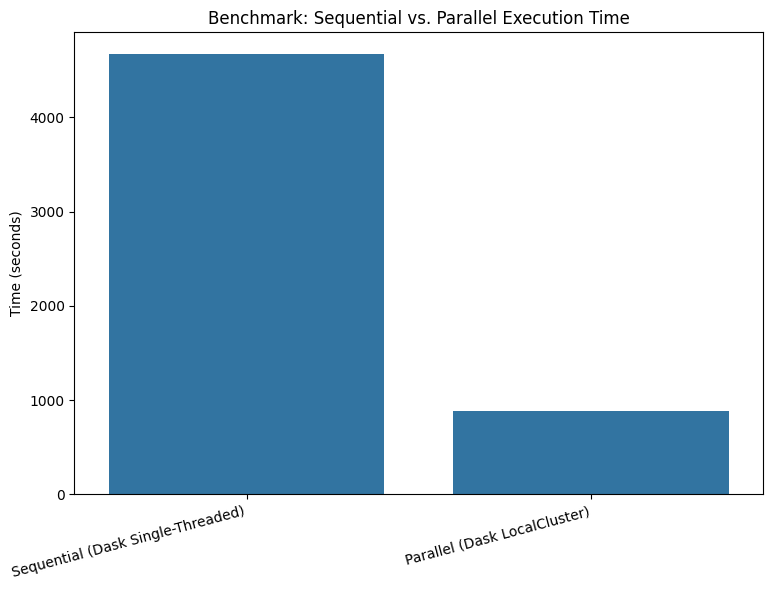

In [9]:
# Run the full pipeline using a Dask LocalCluster for parallel execution.
# Compare its performance against the sequential benchmark.

print("\n--- Starting Parallel Benchmark ---")


cluster = LocalCluster(silence_logs=logging.ERROR)
client = Client(cluster)
print(f"Dask Client for parallel run: {client}")
print(f"Dashboard link for parallel run: {client.dashboard_link}")
print("Please open the Dask Dashboard to observe the parallel execution.")

start_time_parallel = time.time()

# Run the full pipeline
print("Loading and preprocessing data (in parallel)...")
X_parallel, y_parallel, feature_cols_parallel = load_and_preprocess_data(file_pattern)

print("Running ML task (in parallel)...")
model_parallel = run_ml_task(X_parallel, y_parallel)

end_time_parallel = time.time()
parallel_duration = end_time_parallel - start_time_parallel

print(f"\nParallel Benchmark Complete.")
print(f"Total time taken (parallel Dask): {parallel_duration:.2f} seconds")

# Performance Comparison
print("\n--- Performance Comparison ---")
print(f"Sequential execution time: {sequential_duration:.2f} seconds")
print(f"Parallel execution time: {parallel_duration:.2f} seconds")
if (
    parallel_duration > 0 and sequential_duration > 0
):  # ensure sequential_duration is also positive
    speedup = sequential_duration / parallel_duration
    print(f"Speedup: {speedup:.2f}x")
else:
    print(
        "Parallel or sequential execution was too fast, zero, or an error occurred, cannot calculate speedup."
    )

# Plotting the results
times = [sequential_duration, parallel_duration]
labels = ["Sequential (Dask Single-Threaded)", "Parallel (Dask LocalCluster)"]

if sequential_duration > 0 and parallel_duration > 0:  # Only plot if times are valid
    plt.figure(figsize=(8, 6))
    sns.barplot(x=labels, y=times)
    plt.title("Benchmark: Sequential vs. Parallel Execution Time")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot due to invalid execution times.")

# Experimenting with Dask Task Graph Design

In [11]:
def pipeline_with_strategic_persist(file_pattern):  # Renamed for clarity
    print("Running pipeline with strategic .persist()...")
    start_time = time.time()

    ddf_loaded = dd.read_csv(file_pattern)  # Load fresh

    # Initial transformations (these are lazy)
    ddf_transformed = ddf_loaded.assign(
        interaction_feature=ddf_loaded["feature_0"] * ddf_loaded["feature_1"],
        polynomial_feature=ddf_loaded["feature_2"] ** 2,
    )

    feature_columns = [
        col
        for col in ddf_transformed.columns
        if col != "target" and col in ddf_loaded.columns
    ]  # Original features
    feature_columns.extend(
        ["interaction_feature", "polynomial_feature"]
    )  # Add new ones

    X_for_scaling = ddf_transformed[feature_columns]
    y_target = ddf_transformed["target"]  # This is a Dask Series

    scaler = DaskStandardScaler()
    X_scaled_lazy = scaler.fit_transform(X_for_scaling)  # X_scaled_lazy is a Dask Array
    y_target_lazy_array = y_target.to_dask_array(
        lengths=True
    )  # Convert y to Dask Array
    if y_target_lazy_array.ndim > 1:
        y_target_lazy_array = y_target_lazy_array.ravel()

    # --- Strategic Persist ---
    # Persist only the fully preprocessed X and y that will feed into ML
    print("Persisting scaled X and target y array before ML...")
    X_persisted = X_scaled_lazy.persist()
    y_persisted = y_target_lazy_array.persist()

    print("X_scaled and y_target_array scheduled for persistence.")

    # Proceed with ML using the persisted collections
    X_train, X_test, y_train, y_test = train_test_split(
        X_persisted,
        y_persisted,
        test_size=0.2,
        random_state=42,
        shuffle=True,
        convert_mixed_types=True,
    )

    model = DaskLinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    duration = time.time() - start_time
    print(f"Pipeline with strategic persist finished in: {duration:.2f} seconds")
    return duration


if "client" not in locals() or client.status == "closed":
    print(
        "Dask client not active. Please ensure Cell 7's client is running or re-initialize."
    )
else:
    duration_persist_exp = pipeline_with_strategic_persist(file_pattern)

    if "parallel_duration" in locals() and parallel_duration > 0:
        print(f"Original parallel duration (from Cell 7): {parallel_duration:.2f}s")
        print(f"Pipeline with strategic persist duration: {duration_persist_exp:.2f}s")
    else:
        print("Original parallel duration not available for comparison.")
        print(f"Pipeline with strategic persist duration: {duration_persist_exp:.2f}s")

Running pipeline with strategic .persist()...
Persisting scaled X and target y array before ML...
X_scaled and y_target_array scheduled for persistence.
Pipeline with strategic persist finished in: 384.09 seconds
Original parallel duration (from Cell 7): 887.81s
Pipeline with strategic persist duration: 384.09s


Comparison of All Benchmark Results


--- Comparison of All Benchmark Results ---

--- 📊 Summary Table of Benchmark Results ---
                      Benchmark  Execution Time (s) Speedup (vs Seq.)
             Sequential (1W/1T)         4666.637851             1.00x
      Parallel (Default Config)          887.807732             5.26x
Parallel with Strategic Persist          384.090733            12.15x


/var/folders/4z/jxw2hf2n7ws6y7stm6zbhjy80000gn/T/ipykernel_26160/4289164906.py:109: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/nikodemwojtczak/miniconda3/envs/fhnw2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


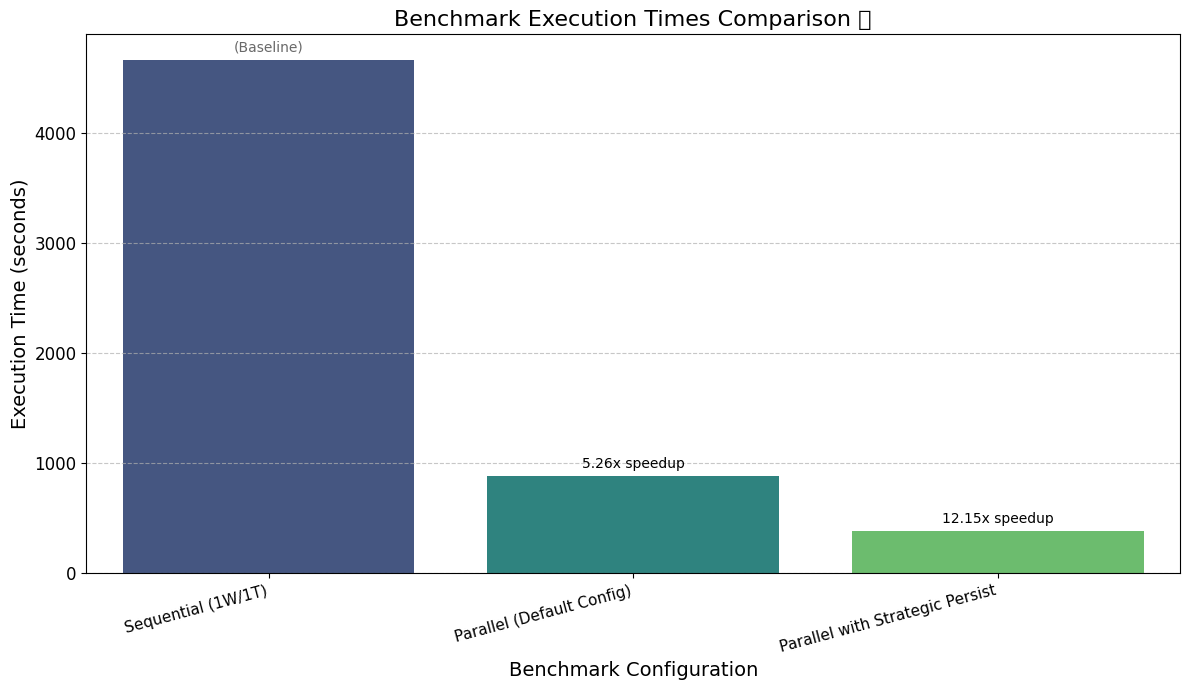

In [17]:
# This cell collects results from the previous benchmarks
# (Sequential, Parallel, and Experiment with Persist) and displays
# a comparative summary table and a bar chart of execution times.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # For np.nan if results are missing

print("\n--- Comparison of All Benchmark Results ---")

benchmark_labels = []
execution_times = []
speedup_factors = []  # To store speedup relative to the sequential run

# Define a placeholder for sequential time if it's not available for speedup calculation
base_sequential_time_for_speedup = np.nan

# 1. Sequential Benchmark Results
if (
    "sequential_duration" in locals()
    and isinstance(sequential_duration, (int, float))
    and sequential_duration > 0
):
    benchmark_labels.append("Sequential (1W/1T)")
    execution_times.append(sequential_duration)
    base_sequential_time_for_speedup = sequential_duration
    speedup_factors.append(1.0)  # Speedup relative to itself is 1x
else:
    print("⚠️ Sequential benchmark results not available or invalid.")

# 2. Parallel Benchmark Results
if (
    "parallel_duration" in locals()
    and isinstance(parallel_duration, (int, float))
    and parallel_duration > 0
):
    benchmark_labels.append("Parallel (Default Config)")
    execution_times.append(parallel_duration)
    if not np.isnan(base_sequential_time_for_speedup):
        speedup_factors.append(base_sequential_time_for_speedup / parallel_duration)
    else:
        speedup_factors.append(np.nan)

else:
    print("⚠️ Parallel benchmark results not available or invalid.")

# 3. Experiment with Persist Results
if (
    "duration_persist_exp" in locals()
    and isinstance(duration_persist_exp, (int, float))
    and duration_persist_exp > 0
):
    benchmark_labels.append("Parallel with Strategic Persist")
    execution_times.append(duration_persist_exp)
    if not np.isnan(base_sequential_time_for_speedup):
        speedup_factors.append(base_sequential_time_for_speedup / duration_persist_exp)
    else:
        speedup_factors.append(np.nan)

else:
    print("⚠️ Experiment (Persist) results not available or invalid.")

if benchmark_labels:

    min_len = min(len(benchmark_labels), len(execution_times), len(speedup_factors))

    results_df = pd.DataFrame(
        {
            "Benchmark": benchmark_labels[:min_len],
            "Execution Time (s)": execution_times[:min_len],
            "Speedup (vs Seq.)": speedup_factors[:min_len],
        }
    )
    results_df["Speedup (vs Seq.)"] = results_df["Speedup (vs Seq.)"].map(
        lambda x: f"{x:.2f}x" if pd.notnull(x) else "N/A"
    )

    print("\n--- 📊 Summary Table of Benchmark Results ---")
    print(results_df.to_string(index=False))

    if execution_times:
        plt.figure(figsize=(12, 7))
        plot_df = results_df.copy()
        plot_df["Speedup Factor"] = [
            s.replace("x", "").replace("N/A", "NaN")
            for s in plot_df["Speedup (vs Seq.)"]
        ]
        plot_df["Speedup Factor"] = pd.to_numeric(
            plot_df["Speedup Factor"], errors="coerce"
        )

        ax = sns.barplot(
            x="Benchmark",
            y="Execution Time (s)",
            data=plot_df,
            palette="viridis",
            hue="Benchmark",
            dodge=False,
            legend=False,
        )

        plt.title("Benchmark Execution Times Comparison ⏱️", fontsize=16)
        plt.xlabel("Benchmark Configuration", fontsize=14)
        plt.ylabel("Execution Time (seconds)", fontsize=14)
        plt.xticks(rotation=15, ha="right", fontsize=11)  # Adjusted fontsize
        plt.yticks(fontsize=12)
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        # Add text annotations for speedup factors on the bars
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            speedup_val = plot_df["Speedup Factor"].iloc[i]
            if pd.notnull(speedup_val) and speedup_val != 1.0:
                ax.text(
                    p.get_x() + p.get_width() / 2.0,
                    height + 0.01 * max(execution_times),  # Position above bar
                    f"{speedup_val:.2f}x speedup",
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    color="black",
                )
            elif pd.notnull(speedup_val) and speedup_val == 1.0:
                ax.text(
                    p.get_x() + p.get_width() / 2.0,
                    height + 0.01 * max(execution_times),
                    "(Baseline)",
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    color="dimgray",
                )

        plt.tight_layout()
        plt.show()
    else:
        print("🚫 No valid execution times to plot.")

else:
    print("\n🚫 No benchmark data available to display or plot.")